In [2]:
import keras.layers as KL
from keras.models import Model
import keras.backend as K
import tensorflow as tf
from keras.utils import np_utils
from  keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
%matplotlib inline

In [4]:
from keras.datasets import mnist

In [5]:
 #创建resnet网络结构
def building_block(filters,block):
    #判断block1和2
    if block != 0: #如果不等于0 那么使用 stride=1
        stride = 1
    else:         #如果等于0 采用stride 2 两倍下采样 也就是 如果是 building1 使用2倍下采样
        stride = 2

    def f(x):
        #主通路结构
        y = KL.Conv2D(filters=filters,kernel_size=(1,1),strides=stride)(x)
        y = KL.BatchNormalization(axis=3)(y)
        y = KL.Activation('relu')(y)
                                        #注意这里没有stride使用padding same就是保证size相同
        y = KL.Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(y) 
        y = KL.BatchNormalization(axis=3)(y)
        y = KL.Activation('relu')(y)

        #主通路输出
        y = KL.Conv2D(filters=4*filters,kernel_size=(1,1))(y)
        y = KL.BatchNormalization(axis=3)(y)

        #判断是哪个block 设定不同的 shortcut支路参数
        if block == 0 : #如果是0 那么就是block1的通路
            shortcut = KL.Conv2D(filters=4*filters,kernel_size=(1,1),strides=stride)(x)
            shortcut = KL.BatchNormalization()(shortcut)

        else:
            #如果不等于0 那就是block2  那么就直接接input的tensor
            shortcut = x

        #主通路和shortcut 相加
        y = KL.Add()([y,shortcut]) #y主 shortcut支路 直接通过add层相加
        y = KL.Activation('relu')(y)
        return y
    return f

In [11]:

#resnet fp提取
def ResNet_Extractor(X_train, Y_train,X_test,Y_test):
    input = KL.Input([28,28,1])
    x = KL.Conv2D(filters=64,kernel_size=(3,3),padding='same')(input)
    x = KL.BatchNormalization(axis=3)(x)
    x = KL.Activation('relu')(x)
   

    #控制调用网络结构
    #每个stage要有不同的 block 12222的数量 ，还有 第一个Block1 输入维度后边要迭代（stage）
    filters = 64
    block = [2,2] # 设定block布局
    for i,block_num in enumerate(block):
        print ('---stage--', str(i) ,'---')
        for block_id in range(block_num):
            print('---block--', str(block_id) ,'---')
            x = building_block(filters=filters,block=block_id)(x)
        filters *= 2 #每个stage double filter个数
     #注意这里的输出就是我们常规的featuremap的输出x
    x = KL.AveragePooling2D(pool_size=(2, 2))(x)
    x = KL.Flatten()(x)
    x = KL.Dense(10, activation='softmax')(x)
   #定义输入输出
    model = Model(inputs=input, outputs=x)
    #打印网络
    print (model.summary())
    plot_model(model,to_file='resMnist6-9-2.png',show_shapes=True)
    #编译网络
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    history = model.fit(
        X_train,
        Y_train,
        epochs=6,
        batch_size=200,
        verbose=1,
        validation_data = (X_test,Y_test),
    )
#     # SAVE your work -model
     
    model.save('./mnistRES2.h5')
    
    #打印graph
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train","test"],loc="upper left")
    plt.show()
    
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
  
    

    return model


(60000, 28, 28)
(60000, 28, 28, 1)
---stage-- 0 ---
---block-- 0 ---
---block-- 1 ---
---stage-- 1 ---
---block-- 0 ---
---block-- 1 ---
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_34 (Conv2D)              (None, 28, 28, 64)   640         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_34 (BatchNo (None, 28, 28, 64)   256         conv2d_34[0][0]                  
__________________________________________________________________________________________________
activation_28 (Activation)      (None, 28, 28, 64)   0           batch_

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/6
60000/60000 [==============================] - 1344s 22ms/step - loss: 0.1873 - acc: 0.9499 - val_loss: 0.0671 - val_acc: 0.9786
Epoch 2/6
60000/60000 [==============================] - 1334s 22ms/step - loss: 0.0353 - acc: 0.9885 - val_loss: 0.0521 - val_acc: 0.9854
Epoch 3/6
60000/60000 [==============================] - 1337s 22ms/step - loss: 0.0259 - acc: 0.9915 - val_loss: 0.0506 - val_acc: 0.9858
Epoch 4/6
60000/60000 [==============================] - 1334s 22ms/step - loss: 0.0240 - acc: 0.9925 - val_loss: 0.0414 - val_acc: 0.9883
Epoch 5/6
60000/60000 [==============================] - 1343s 22ms/step - loss: 0.0206 - acc: 0.9935 - val_loss: 0.0456 - val_acc: 0.9871
Epoch 6/6
60000/60000 [==============================] - 1334s 22ms/step - loss: 0.0166 - acc: 0.9947 - val_loss: 0.0388 - val_acc: 0.9885


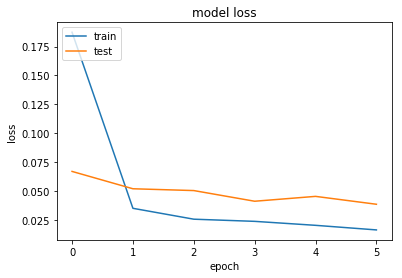

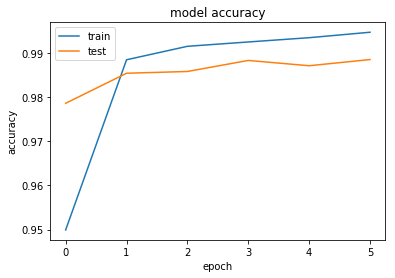

In [12]:

def main():
    (X_train,Y_train),(X_test,Y_test) = mnist.load_data()
    print(X_train.shape)
    
    X_train = X_train.reshape(-1,28,28,1)
    
    X_test = X_test.reshape(-1,28,28,1)
    print (X_train.shape)
    #-set type into float32 设置成浮点型
    X_train = X_train.astype('float32')  #astype SET AS TYPE into 
    X_test = X_test.astype('float32')
    X_train = X_train/255.0
    X_test /=255.0

    #Class vectors [0,0,0,0,0,0,0,1(7),0,0] #转成二进制
    Y_test = np_utils.to_categorical(Y_test,10) #定义LABEL类数量
    Y_train = np_utils.to_categorical(Y_train,10)

    ResNet_Extractor(X_train, Y_train,X_test,Y_test)

main()

